##### 4: Soil Temperature

Soil temperature is a fundamental metric in ecological studies, affecting vital ecological processes such as biogeochemical cycling, decomposition rates, and root and soil biota activity. Additionally, it plays a significant role in the hydrological cycle by determining the state of soil water, whether it is liquid or solid.

The NEON Soil Temperature dataset provides information about soil temperature variations at different depths below the soil surface, ranging from approximately 2 cm to 200 cm (up to 300 cm at Alaskan sites). This dataset offers 1-minute and 30-minute average measurements, allowing researchers to observe temporal trends and patterns with high granularity.

Throughout this section, we will guide you through processing soil temperature data downloaded in the earlier section of this tutorial. Here, we will guide you through preprocessing, visualization, and analysis techniques, empowering you to derive meaningful insights from the NEON soil temperature dataset.

In [1]:
# Reading the Downloaded and unzipped files
import os
os.listdir('/Volumes/Thomas/Tutorials/NEON/Data/filesToStack00041/stackedFiles/')

['ST_30_minute.csv',
 'variables_00041.csv',
 'readme_00041.txt',
 'citation_00041_RELEASE-2024.txt',
 'sensor_positions_00041.csv',
 'issueLog_00041.csv']

In [2]:
import pandas as pd
ST_30_Minute = pd.read_csv('/Volumes/Thomas/Tutorials/NEON/Data/filesToStack00041/stackedFiles/ST_30_minute.csv')
ST_30_Minute['startDateTime'] = pd.to_datetime(ST_30_Minute['startDateTime'])
ST_30_Minute.set_index('startDateTime', inplace=True)
ST_30_Minute.columns

Index(['domainID', 'siteID', 'horizontalPosition', 'verticalPosition',
       'endDateTime', 'soilTempMean', 'soilTempMinimum', 'soilTempMaximum',
       'soilTempVariance', 'soilTempNumPts', 'soilTempExpUncert',
       'soilTempStdErMean', 'finalQF', 'publicationDate', 'release'],
      dtype='object')

In [3]:
columns_of_interest = ['domainID', 'siteID', 'horizontalPosition', 'verticalPosition',
                       'soilTempMean', 'soilTempMinimum', 'soilTempMaximum','finalQF']
st_df = ST_30_Minute[columns_of_interest]
df_t = st_df[(st_df['finalQF'] == 0)]
# Group by date and verticalPosition, then aggregate using mean for mean_cols and first for first_cols
daily_t = df_t.groupby([df_t.index.date, 'verticalPosition']).agg(
    {'domainID': 'first', 'siteID': 'first',
     'soilTempMean': 'mean', 'soilTempMinimum': 'mean',
     'soilTempMaximum': 'mean'}
)

# Reset index to make date and verticalPosition regular columns
daily_t.reset_index(inplace=True)
# Rename level_0 to Date
daily_t.rename(columns={'level_0': 'Date'}, inplace=True)

# Set Date column as index
daily_t.set_index('Date', inplace=True)

In [4]:
sensorp= pd.read_csv('/Volumes/Thomas/Tutorials/NEON/Data/filesToStack00041/stackedFiles/sensor_positions_00041.csv')
# Selecting subset of data
coi = ['siteID', 'HOR.VER', 'xOffset', 'yOffset', 'zOffset']
sensor_l = sensorp[coi].copy()  # Ensure to make a copy

# Convert the column to string type
sensor_l['HOR.VER'] = sensor_l['HOR.VER'].astype(str)

# Splitting the column and creating two new columns
sensor_l[['horizontalPosition',
          'verticalPosition']] = sensor_l['HOR.VER'].str.split('.',expand=True)

# Convert the values back to numeric
sensor_l['horizontalPosition'] = pd.to_numeric(sensor_l['horizontalPosition'])
sensor_l['verticalPosition'] = pd.to_numeric(sensor_l['verticalPosition'])

# Dropping the original column
sensor_l.drop(columns=['HOR.VER'], inplace=True)

In [5]:
sensor_l['zOffset'].unique()

array([-0.02, -0.06, -0.16, -0.26, -0.56, -0.86, -1.12, -1.56, -1.96])

In [6]:
# Creating a new DataFrame to store the result
plot_T = daily_t.copy()

# Creating a dictionary to map sensor depth values based on horizontal and vertical positions
sd = {(row['verticalPosition']): row['zOffset'] 
                    for _, row in sensor_l.iterrows()}

# Function to populate soilDepth column
def psensor_depth(row, sd):
    vertical_pos = row['verticalPosition']
    sd_value = sd.get(vertical_pos)
    return sd_value

# Applying the function to populate soilDepth column
plot_T['zOffset'] = plot_T.apply(lambda row: psensor_depth(row, sd), axis=1)

In [16]:
plot_T.head()

,verticalPosition,domainID,siteID,soilTempMean,soilTempMinimum,soilTempMaximum,zOffset
Date,,,,,,,
2017-07-13,501,D08,TALL,26.431933,26.262250,26.601667,-0.02
2017-07-13,502,D08,TALL,26.130200,26.009479,26.249046,-0.06
2017-07-13,503,D08,TALL,25.530112,25.467883,25.592025,-0.16
2017-07-13,504,D08,TALL,25.053558,25.020608,25.086546,-0.26
2017-07-13,505,D08,TALL,24.051950,24.046342,24.057625,-0.56


In [7]:
import numpy as np
x = plot_T.index.unique()
y = plot_T['zOffset'].unique()
X, Y = np.meshgrid(x, y)
depth_values = plot_T['zOffset'].unique()
dates = plot_T.index.unique()

# Initialize 2D array to store VSWCMean values
plot_var = np.zeros((len(depth_values), len(dates)))
depth_values = plot_T['zOffset'].unique()
dates = plot_T.index.unique()

# Iterate over unique depth values
for i, depth_value in enumerate(depth_values):
    # Filter DataFrame for the current depth value
    filtered_data = plot_T[plot_T['zOffset'] == depth_value]
    # Iterate over unique dates
    for j, date in enumerate(dates):
        # Check if the date exists in the DataFrame
        if date in filtered_data.index:
            # Get soil temperature values for the current depth value and date
            st = filtered_data.loc[date, 'soilTempMean']
            # Calculate the mean of temperature values
            st_mean = st.mean() if isinstance(st, pd.Series) else st
            # Store mean temperature value in 2D array
            plot_var[i, j] = st_mean

print(X.shape, Y.shape, plot_var.shape)

(9, 2153) (9, 2153) (9, 2153)


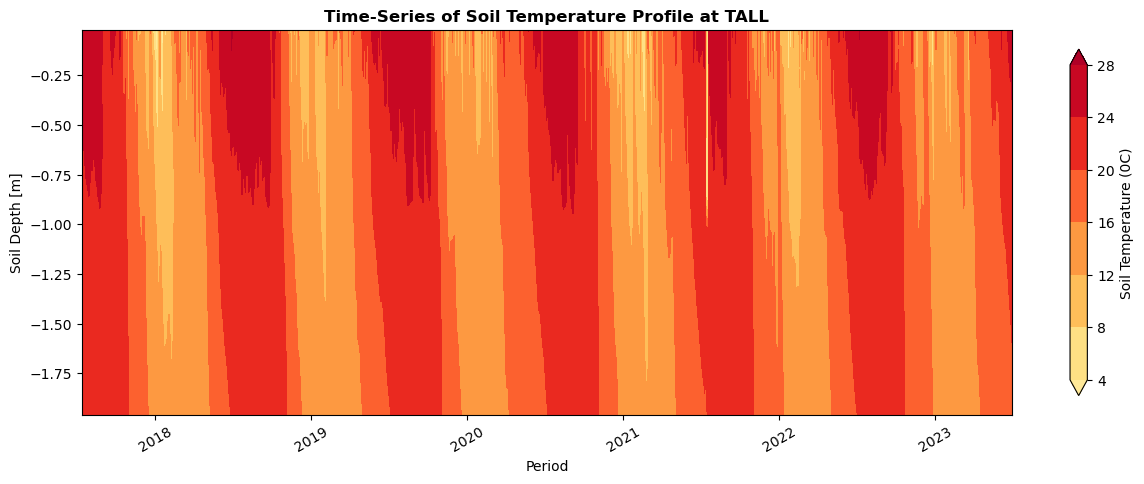

In [8]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('YlOrRd')
cmap = truncate_colormap(cmap, 0.15, 0.9)

fig= plt.figure(num=None, figsize=(15,5),  facecolor='w', edgecolor='k')
ax = plt.gca()
cs = ax.contourf(X, Y, plot_var,cmap=cmap,extend="both")
plt.xticks(rotation=30)
plt.ylabel('Soil Depth [m]')
plt.xlabel('Period')
plt.title ('Time-Series of Soil Temperature Profile at TALL',fontweight="bold")
cbar = fig.colorbar(cs, ax=ax, shrink=0.9)
y_label = 'Soil Temperature (0C)'
cbar.ax.set_ylabel(y_label)
plt.show()

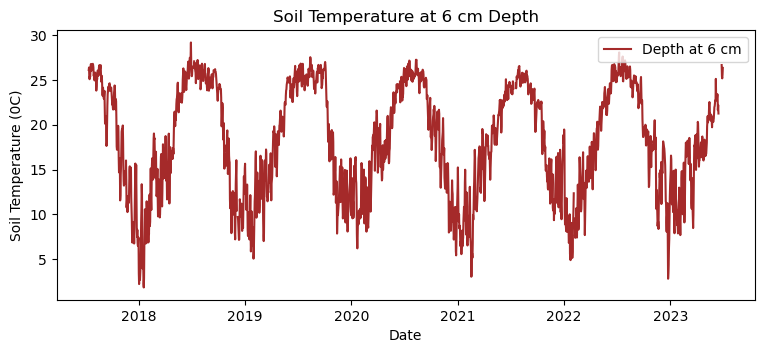

In [13]:
# Convert the index to a datetime-like object
plot_T.index = pd.to_datetime(plot_T.index)

# Making a time series plot for soil temperature at 6 cm
st_6cm = plot_T[plot_T['verticalPosition'].astype(str).str.startswith('502')]
daily_st = st_6cm['soilTempMean'].resample('D').mean().to_frame()
plt.figure(figsize=(9, 3.5))
plt.plot(daily_st.index, daily_st['soilTempMean'], color = 'brown', label='Depth at 6 cm')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Soil Temperature (0C)')
plt.title('Soil Temperature at 6 cm Depth')
plt.legend(loc = 'upper right')

# Display the plot
plt.show()

In [17]:
# Group by date and vertical position, and aggregate by taking the mean over horizontal position
data_plots = plot_T.groupby([plot_T.index, 'verticalPosition']).agg({
    'soilTempMean': 'mean',
    'soilTempMinimum': 'mean',
    'soilTempMaximum': 'mean',
    'zOffset': 'first'
})

# Reset index to make 'verticalPosition' and 'Date' regular columns
data_plots.reset_index(inplace=True)

columns = ['Date', 'soilTempMean', 'zOffset']
df_1 = data_plots[columns]
df_1.to_csv('TALL_daily_SoilTemp.csv')
df_1.head()

,Date,soilTempMean,zOffset
0,2017-07-13,26.431933,-0.02
1,2017-07-13,26.130200,-0.06
2,2017-07-13,25.530112,-0.16
3,2017-07-13,25.053558,-0.26
4,2017-07-13,24.051950,-0.56
